# Loading & Preprocessing

In [ ]:
import json
import math
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('drive/MyDrive/data/train/benign',128))
malign_train = np.array(Dataset_loader('drive/MyDrive/data/train/malignant',128))
normal_train = np.array(Dataset_loader('drive/MyDrive/data/train/normal',128))
benign_test = np.array(Dataset_loader('drive/MyDrive/data/validation/benign',128))
malign_test = np.array(Dataset_loader('drive/MyDrive/data/validation/malignant',128))
normal_test = np.array(Dataset_loader('drive/MyDrive/data/validation/normal',128))

100%|██████████| 1837/1837 [00:04<00:00, 402.75it/s]


# Create Label

In [ ]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
normal_train_label = np.full(len(normal_train), 2)
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
normal_test_label = np.full(len(normal_test), 2)
# Merge data 
X_train = np.concatenate((benign_train, malign_train, normal_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label, normal_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test, normal_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label, normal_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

# Train and Evalutation split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

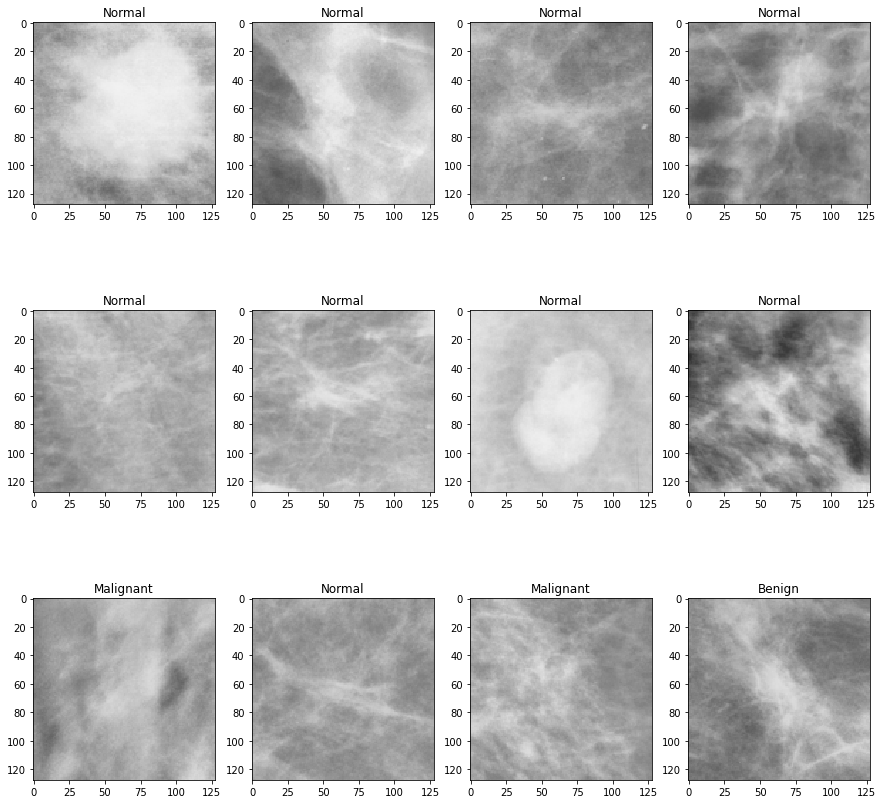

In [ ]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    elif np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Malignant')
    else:
        ax.title.set_text('Normal')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [ ]:
BATCH_SIZE = 6

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )



```
# This is formatted as code
```

# Model: 

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(3, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3)                 5763      
                                                                 
Total params: 18,335,427
Trainable params: 18,102,531
No

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-10-b7b960b0426a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
1197/1197 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.7591

1197/1197 [==============================] - 190s 131ms/step - loss: 0.4078 - accuracy: 0.7591 - val_loss: 0.2693 - val_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 2/20
1197/1197 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.8289

1197/1197 [==============================] - 146s 122ms/step - loss: 0.3173 - accuracy: 0.8289 - val_loss: 0.3154 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 3/20
1197/1197 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8343

1197/1197 [==============================] - 153s 128ms/step - loss: 0.3010 - accuracy: 0.8343 - val_loss: 0.3029 - val_accuracy: 0.8641 - lr: 1.0000e-04
Epoch 4/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.8361

1197/1197 [==============================] - 155s 130ms/step - loss: 0.2949 - accuracy: 0.8361 - val_loss: 0.2371 - val_accuracy: 0.8725 - lr: 1.0000e-04
Epoch 5/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.8368

1197/1197 [==============================] - 160s 134ms/step - loss: 0.2919 - accuracy: 0.8368 - val_loss: 0.2684 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 6/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.8386

1197/1197 [==============================] - 158s 132ms/step - loss: 0.2885 - accuracy: 0.8386 - val_loss: 0.2533 - val_accuracy: 0.8647 - lr: 1.0000e-04
Epoch 7/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.8382

1197/1197 [==============================] - 150s 125ms/step - loss: 0.2855 - accuracy: 0.8382 - val_loss: 0.2239 - val_accuracy: 0.8775 - lr: 1.0000e-04
Epoch 8/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8390

1197/1197 [==============================] - 153s 128ms/step - loss: 0.2819 - accuracy: 0.8390 - val_loss: 0.3847 - val_accuracy: 0.8096 - lr: 1.0000e-04
Epoch 9/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8438

1197/1197 [==============================] - 149s 124ms/step - loss: 0.2787 - accuracy: 0.8438 - val_loss: 0.3793 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 10/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.8393

1197/1197 [==============================] - 149s 124ms/step - loss: 0.2704 - accuracy: 0.8393 - val_loss: 0.2524 - val_accuracy: 0.8614 - lr: 1.0000e-04
Epoch 11/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.8489

1197/1197 [==============================] - 146s 122ms/step - loss: 0.2645 - accuracy: 0.8489 - val_loss: 0.2578 - val_accuracy: 0.8575 - lr: 1.0000e-04
Epoch 12/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.8500

1197/1197 [==============================] - 151s 126ms/step - loss: 0.2646 - accuracy: 0.8500 - val_loss: 0.7979 - val_accuracy: 0.3558 - lr: 1.0000e-04
Epoch 13/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.8503

1197/1197 [==============================] - 151s 126ms/step - loss: 0.2574 - accuracy: 0.8503 - val_loss: 0.1993 - val_accuracy: 0.8814 - lr: 1.0000e-04
Epoch 14/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8486

1197/1197 [==============================] - 145s 121ms/step - loss: 0.2577 - accuracy: 0.8486 - val_loss: 0.2639 - val_accuracy: 0.8658 - lr: 1.0000e-04
Epoch 15/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.8502

1197/1197 [==============================] - 150s 126ms/step - loss: 0.2579 - accuracy: 0.8502 - val_loss: 0.2304 - val_accuracy: 0.8658 - lr: 1.0000e-04
Epoch 16/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.8544

1197/1197 [==============================] - 150s 125ms/step - loss: 0.2488 - accuracy: 0.8544 - val_loss: 0.2156 - val_accuracy: 0.8797 - lr: 1.0000e-04
Epoch 17/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.8566

1197/1197 [==============================] - 145s 121ms/step - loss: 0.2521 - accuracy: 0.8566 - val_loss: 0.2685 - val_accuracy: 0.8380 - lr: 1.0000e-04
Epoch 18/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.8530

1197/1197 [==============================] - 150s 125ms/step - loss: 0.2502 - accuracy: 0.8530 - val_loss: 0.2287 - val_accuracy: 0.8803 - lr: 1.0000e-04
Epoch 19/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.8570

1197/1197 [==============================] - 149s 125ms/step - loss: 0.2438 - accuracy: 0.8570 - val_loss: 0.9297 - val_accuracy: 0.2962 - lr: 1.0000e-04
Epoch 20/20
1197/1197 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.8514

1197/1197 [==============================] - 149s 125ms/step - loss: 0.2503 - accuracy: 0.8514 - val_loss: 0.2381 - val_accuracy: 0.8591 - lr: 1.0000e-04


In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
model.save("my_model.h5")

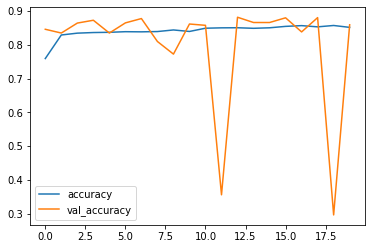

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

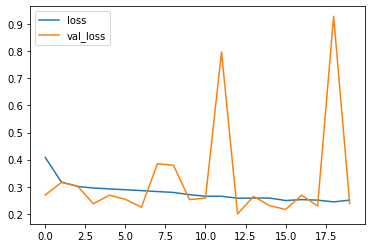

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [ ]:
Y_val_pred = model.predict(x_val)

57/57 [==============================] - 7s 58ms/step


In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.85913140311804

In [ ]:
Y_pred = model.predict(X_test)

70/70 [==============================] - 6s 86ms/step


In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-17-6b1627227319>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████| 10/10 [03:06<00:00, 18.63s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[   7   93   76]
 [   3  154   66]
 [   1  143 1693]]


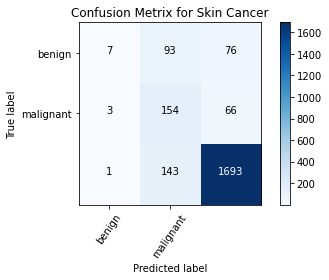

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[   4   48  124]
 [   1  107  115]
 [   1   17 1819]]


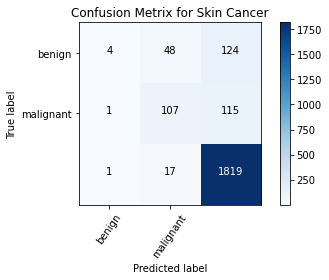

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')